## Full Project Pipline

In [14]:
import sys
import os
import pandas as pd
from PIL import Image
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image
from IPython.display import display

# Custom functions
from Data.TextData.Subsample import sample_data, process_and_save
from Data.TextData.MergeData import merge_data
from Data.ImageData.select_tifs import copy_tif_files
from Modelling.TrainTestSplit.TrainTestSplitNew import process_text_data, split_data, generate_and_save_augmented_images
from Data.ImageData.SplitImagesNew import extract_vignettes
from Modelling.CNN.CNNnew import preprocess_data, create_tf_datasets, build_model, cnn_evaluate_model, plot_hist
from Modelling.MLP.MLPnew import load_and_preprocess, mlp_evaluate_model
from Modelling.CollaborativeModel.CollabModelNew import prepare_data, train_collaborative_model

## Create subsample


Due to computational limitations, we will use a subset of the data to perform our analysis. The code block below selects a random sample of 100 water samples from the Master Table. Note that each row in the Master Table corresponds to a water sample. 

In [3]:
# Set base directory and output directory
base_dir = "/Users/adelelauzon/Desktop/MSc/STA5243"
output_dir = "/Users/adelelauzon/Desktop/MSc/STA5243/ZooplanktonGit/Data/TextData"
# Read in Master Table (environmental data)
master = pd.read_excel("/Users/adelelauzon/Desktop/MSc/STA5243/ZooplanktonGit/Data/TextData/MasterTable_AI_FlowCAM.xlsx", sheet_name="MasterTable")
# Take a random subsample of 100 rows. 
# Recall that each row here represents a water sample/mosaic. 
subsample = sample_data(master, n=100, seed=1013)
subsample = process_and_save(subsample, base_dir=base_dir, output_dir=output_dir, output_file="subsample.csv")



In [5]:
# View subsample
subsample

,tifffile,csvfile,Year,SAM,Month,Day,Rep,repnum,Key,Loc,...,volbest,WhitefishDen,UnknwCoregonine,CiscoDen,Exposure,SmeltDen,YPerchDen,BurbotDen,OtherFishDen,ODLocation
3231,20180503_Huron_075_2mm_rep1_000037.tif,20180503_FISHI_075_2mm_rep1_data.csv,2018,75,5,3,rep1,1,2018.Huron.075.1,FISHI,...,47.047516,0.051572,0.000000,0.012893,1.497829e+07,0.0,0.000000,0.000000,0.0,/Users/adelelauzon/Desktop/MSc/STA5243/CSVs/20...
6126,20180529_Huron_323_2mm_rep2_redo_000008.tif,20180529_FISHI_323_2mm_rep2_data.csv,2018,323,5,29,rep2,2,2018.Huron.323.2,FISHI,...,39.430640,0.000000,0.007060,0.000000,7.415978e+04,0.0,0.360049,0.000000,0.0,/Users/adelelauzon/Desktop/MSc/STA5243/CSVs/20...
6180,20180529_Huron_323_2mm_rep3_000047.tif,20180529_FISHI_323_2mm_rep3_data.csv,2018,323,5,29,rep3,3,2018.Huron.323.3,FISHI,...,39.430640,0.000000,0.007060,0.000000,7.415978e+04,0.0,0.360049,0.000000,0.0,/Users/adelelauzon/Desktop/MSc/STA5243/CSVs/20...
5297,20180523_Huron_239_2mm_rep2_000001.tif,20180523_FISHI_239_2mm_rep2_data.csv,2018,239,5,23,rep2,2,2018.Huron.239.2,FISHI,...,40.965071,0.055334,0.000000,0.096834,3.813943e+06,0.0,0.041500,0.000000,0.0,/Users/adelelauzon/Desktop/MSc/STA5243/CSVs/20...
45,04072021_Huron_10_2mm_Rep3_AD_000007.tif,20210407_FISHI_010_2mm_Rep3_VC_data.csv,2021,10,4,7,Rep3,3,2021.Huron.010.3,FISHI,...,40.628612,0.000000,0.000000,0.006371,1.542637e+04,0.0,0.000000,0.000000,0.0,/Users/adelelauzon/Desktop/MSc/STA5243/CSVs/20...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1689,20170428_Huron_088_5mm_rep3_000050.tif,20170428_FISHI_088_2mm_rep3_CT_data.csv,2017,88,4,28,rep3,3,2017.Huron.088.3,FISHI,...,16.455305,0.229489,0.000000,0.052959,1.253858e+08,0.0,0.000000,0.000000,0.0,/Users/adelelauzon/Desktop/MSc/STA5243/CSVs/20...
1389,20170426_Huron_080_2mm_rep3_000014.tif,20170426_FISHI_080_2mm_rep3_KG_data.csv,2017,80,4,26,rep3,3,2017.Huron.080.3,FISHI,...,23.333295,0.018501,0.000000,0.009250,1.795642e+06,0.0,0.000000,0.000000,0.0,/Users/adelelauzon/Desktop/MSc/STA5243/CSVs/20...
3443,20180508_Huron_115_2mm_rep2_000029.tif,20180508_FISHI_115_2mm_rep2_data.csv,2018,115,5,8,rep2,2,2018.Huron.115.2,FISHI,...,33.017406,3.252560,0.324010,2.180835,1.071284e+06,0.0,0.000000,0.000000,0.0,/Users/adelelauzon/Desktop/MSc/STA5243/CSVs/20...
6952,20190523_Huron_244_2mm_rep4_000005.tif,20190523_FISHI_244_2mm_Rep4_VC_data.csv,2019,244,5,23,rep4,4,2019.Huron.244.4,FISHI,...,35.816296,0.000000,0.006268,0.000000,1.670877e+05,0.0,0.050140,0.000000,0.0,/Users/adelelauzon/Desktop/MSc/STA5243/CSVs/20...


In [7]:
# Define input and output directories
base_dir = "/Users/adelelauzon/Desktop/MSc/STA5243"
output_dir = "/Users/adelelauzon/Desktop/MSc/STA5243/ZooplanktonGit/Data/TextData"

# Load input datasets
geometric = pd.read_csv("/Users/adelelauzon/Desktop/MSc/STA5243/ZooplanktonGit/Data/TextData/subsample.csv")  
environmental = pd.read_excel("/Users/adelelauzon/Desktop/MSc/STA5243/ZooplanktonGit/Data/TextData/MasterTable_AI_FlowCAM.xlsx", sheet_name="MasterTable")



Each water sample has a corresponding CSV of geometric data for each particle in the sample. The code block below creates a new merged dataset, where each row contains the geometric data for a specific particle, as well as the environmental information that is common to the particle's original sample. 

In [8]:
# Create merged dataset of geometric and environmental data
merged_data = merge_data(base_dir, output_dir, geometric, environmental)


Finished searching through the list of CSV files.


In [9]:
cleaned_merged = pd.read_csv("Data/TextData/cleaned_merged.csv")
cleaned_merged

,Class.Particle.ID,Class,Area..ABD.,Area..Filled.,Aspect.Ratio,Calibration.Image,Capture.X,Capture.Y,Circle.Fit,Circularity,...,distshore,FR,volbest,WhitefishDen,UnknwCoregonine,CiscoDen,Exposure,YPerchDen,BurbotDen,OtherFishDen
0,1.0,Calanoid_1,224558.8685,224558.8685,0.7355,1,182,327,0.0000,0.0696,...,358.863202,Fixed,47.047516,0.051572,0.000000,0.012893,1.497829e+07,0.00000,0.0,0.0
1,2.0,Calanoid_1,139744.7741,139826.2272,0.4364,1,282,912,0.0000,0.1592,...,358.863202,Fixed,47.047516,0.051572,0.000000,0.012893,1.497829e+07,0.00000,0.0,0.0
2,3.0,Calanoid_1,505978.7217,526853.4321,0.5498,1,121,1389,0.2665,0.2930,...,358.863202,Fixed,47.047516,0.051572,0.000000,0.012893,1.497829e+07,0.00000,0.0,0.0
3,76.0,Calanoid_1,141700.2456,141700.2456,0.2783,1,913,842,0.0000,0.3383,...,358.863202,Fixed,47.047516,0.051572,0.000000,0.012893,1.497829e+07,0.00000,0.0,0.0
4,4.0,Calanoid_1,194817.8498,199446.2763,0.2468,1,809,317,0.0000,0.3470,...,358.863202,Fixed,47.047516,0.051572,0.000000,0.012893,1.497829e+07,0.00000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23444,2.0,Bosmina_1,134942.9571,135024.2786,0.8062,1,964,1461,0.3711,0.3688,...,62.657072,Fixed,35.816296,0.000000,0.006268,0.000000,1.670877e+05,0.05014,0.0,0.0
23445,3.0,Bosmina_1,221320.3511,221569.4058,0.9560,1,722,1057,0.7220,0.6822,...,62.657072,Fixed,35.816296,0.000000,0.006268,0.000000,1.670877e+05,0.05014,0.0,0.0
23446,7.0,Herpacticoida,130149.0943,130149.0943,0.2780,1,335,244,0.0000,0.1311,...,62.657072,Fixed,35.816296,0.000000,0.006268,0.000000,1.670877e+05,0.05014,0.0,0.0
23447,4.0,Bosmina_1,146022.9073,146512.6327,0.5989,1,130,899,0.4726,0.6888,...,62.657072,Fixed,35.816296,0.000000,0.006268,0.000000,1.670877e+05,0.05014,0.0,0.0


In [10]:
class_counts = cleaned_merged["Class"].value_counts()
class_counts

Class
Calanoid_1       21206
Bosmina_1         1120
Chironomid         615
Herpacticoida      468
Chydoridae          37
Daphnia              3
Name: count, dtype: int64

Note the fairly extreme class imbalance in this dataset. Further, note that one of the 7 "important" classes is missing. 

### Preprocess Data

For the first step of data processing, we will move the necessary tif files (FlowCam mosaics) to a new folder. 

In [11]:
# Select relevant tif files
source_dir = "/Users/adelelauzon/Desktop/MSc/STA5243/HURON_OverlapTiffsWithPP"
output_dir = "/Users/adelelauzon/Desktop/MSc/STA5243/tifs"
data_cleaned_path = "/Users/adelelauzon/Desktop/MSc/STA5243/ZooplanktonGit/Data/TextData/cleaned_merged.csv"

copy_tif_files(source_dir, output_dir, data_cleaned_path) 


File not found: /Users/adelelauzon/Desktop/MSc/STA5243/HURON_OverlapTiffsWithPP/20180509_Huron_139_2mm_rep2_000002.tif
File not found: /Users/adelelauzon/Desktop/MSc/STA5243/HURON_OverlapTiffsWithPP/20180509_Huron_139_2mm_rep2_000005.tif
File not found: /Users/adelelauzon/Desktop/MSc/STA5243/HURON_OverlapTiffsWithPP/20180509_Huron_139_2mm_rep2_000011.tif
File not found: /Users/adelelauzon/Desktop/MSc/STA5243/HURON_OverlapTiffsWithPP/20180509_Huron_139_2mm_rep2_000012.tif
File not found: /Users/adelelauzon/Desktop/MSc/STA5243/HURON_OverlapTiffsWithPP/20180509_Huron_139_2mm_rep2_000025.tif
File not found: /Users/adelelauzon/Desktop/MSc/STA5243/HURON_OverlapTiffsWithPP/20180509_Huron_139_2mm_rep2_000040.tif
File not found: /Users/adelelauzon/Desktop/MSc/STA5243/HURON_OverlapTiffsWithPP/20180509_Huron_139_2mm_rep2_000044.tif
File not found: /Users/adelelauzon/Desktop/MSc/STA5243/HURON_OverlapTiffsWithPP/20180509_Huron_139_2mm_rep2_000044.tif
File not found: /Users/adelelauzon/Desktop/MSc/S

Unfortunately, it looks like there was some data loss -- some CSV files are not able to be found on the local machine. 

Now, we will split the mosaics into their individual vignettes in the code chunk below. We will also create a dataframe, extracted_particles.csv, which stores the filepath, class, and particle ID of each vignette. 

In [12]:
# Split the tif mosaics into particles
extract_vignettes("/Users/adelelauzon/Desktop/MSc/STA5243/ZooplanktonGit/Data/TextData/cleaned_merged.csv", 
                      "/Users/adelelauzon/Desktop/MSc/STA5243/tifs", 
                      "/Users/adelelauzon/Desktop/MSc/STA5243/ZooplanktonGit/Data/ImageData/vignettes", 
                      "/Users/adelelauzon/Desktop/MSc/STA5243/ZooplanktonGit/Data/ImageData/extracted_particles.csv")


Extracted vignette: 20180503_Huron_075_2mm_rep1_000001_vign000000.png
Extracted vignette: 20180503_Huron_075_2mm_rep1_000001_vign000001.png
Extracted vignette: 20180503_Huron_075_2mm_rep1_000002_vign000002.png
Extracted vignette: 20180503_Huron_075_2mm_rep1_000002_vign000003.png
Extracted vignette: 20180503_Huron_075_2mm_rep1_000002_vign000004.png
Extracted vignette: 20180503_Huron_075_2mm_rep1_000002_vign000005.png
Extracted vignette: 20180503_Huron_075_2mm_rep1_000003_vign000006.png
Extracted vignette: 20180503_Huron_075_2mm_rep1_000005_vign000007.png
Extracted vignette: 20180503_Huron_075_2mm_rep1_000005_vign000008.png
Extracted vignette: 20180503_Huron_075_2mm_rep1_000005_vign000009.png
Extracted vignette: 20180503_Huron_075_2mm_rep1_000006_vign000010.png
Extracted vignette: 20180503_Huron_075_2mm_rep1_000006_vign000011.png
Extracted vignette: 20180503_Huron_075_2mm_rep1_000007_vign000012.png
Extracted vignette: 20180503_Huron_075_2mm_rep1_000009_vign000013.png
Extracted vignette: 

The chunk below does three important tasks. First, it oversamples the underrepresented classes, Chydoridae and Daphnia. Then, it splits the image and text data into training, testing, and validation. Finally, for the image data, it generates augmented images for the underrepresented classes as well. 

In [13]:
particle_path = "/Users/adelelauzon/Desktop/MSc/STA5243/ZooplanktonGit/Data/ImageData/extracted_particles.csv"  
text_data_path = "/Users/adelelauzon/Desktop/MSc/STA5243/ZooplanktonGit/Data/TextData/cleaned_merged.csv"  
particles = pd.read_csv(particle_path)
text_data = pd.read_csv(text_data_path)
text_all_cleaned = process_text_data(text_data, seed=42)

# Specify the classes you want to oversample
classes_to_oversample = ('Chydoridae', 'Daphnia')  
train_img, val_img, test_img, train_text, val_text, test_text = split_data(particles, text_all_cleaned, classes_to_oversample, target_count=100)

vignettes_folder = "/Users/adelelauzon/Desktop/MSc/STA5243/ZooplanktonGit/Data/ImageData/vignettes"  

# Generate augmented images for each oversampled class
augmented_images = []
for class_label in classes_to_oversample:
    train_class = train_img[train_img['Class'] == class_label]
    aug_images = generate_and_save_augmented_images(train_class, vignettes_folder, class_label=class_label)
    augmented_images.extend(aug_images)

augmented_df = pd.DataFrame(augmented_images, columns=["Vignette", "Class"])
train_img = pd.concat([train_img, augmented_df])

train_img.to_csv("/Users/adelelauzon/Desktop/MSc/STA5243/ZooplanktonGit/Data/ImageData/image_train.csv", index=False)
val_img.to_csv("/Users/adelelauzon/Desktop/MSc/STA5243/ZooplanktonGit/Data/ImageData/image_val.csv", index=False)
test_img.to_csv("/Users/adelelauzon/Desktop/MSc/STA5243/ZooplanktonGit/Data/ImageData/image_test.csv", index=False)
train_text.to_csv("/Users/adelelauzon/Desktop/MSc/STA5243/ZooplanktonGit/Data/TextData/text_train.csv", index=False)
val_text.to_csv("/Users/adelelauzon/Desktop/MSc/STA5243/ZooplanktonGit/Data/TextData/text_val.csv", index=False)
test_text.to_csv("/Users/adelelauzon/Desktop/MSc/STA5243/ZooplanktonGit/Data/TextData/text_test.csv", index=False)
print("Data augmentation and saving completed.")

Generated 2 augmented images for 20170510_Huron_163_2mm_rep1_000001_vign009534.png
Generated 2 augmented images for 20170510_Huron_163_2mm_rep3_000042_vign011323.png
Generated 2 augmented images for 20170511_Huron_171_2mm_rep1_000015_vign011453.png
Generated 2 augmented images for 20170511_Huron_171_2mm_rep1_000013_vign011451.png
Generated 2 augmented images for 20170511_Huron_171_2mm_rep1_000009_vign011449.png
Generated 2 augmented images for 20180529_Huron_323_2mm_rep3_000052_vign000499.png
Generated 2 augmented images for 20170510_Huron_163_2mm_rep1_000023_vign009725.png
Generated 2 augmented images for 20170510_Huron_163_2mm_rep1_000038_vign009870.png
Generated 2 augmented images for 20170510_Huron_163_2mm_rep3_000031_vign011205.png
Generated 2 augmented images for 20170428_Huron_090_2mm_rep2_000019_vign010540.png
Generated 2 augmented images for 20170510_Huron_163_2mm_rep1_000004_vign009552.png
Generated 2 augmented images for 20170510_Huron_163_2mm_rep3_000020_vign011095.png
Gene

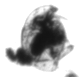

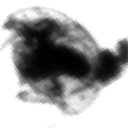

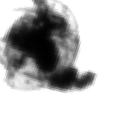

In [16]:
# View augmented images
orig = Image.open('/Users/adelelauzon/Desktop/MSc/STA5243/ZooplanktonGit/Data/ImageData/vignettes/20170428_Huron_088_2mm_rep2_000026_vign011943.png')
aug1 = Image.open('/Users/adelelauzon/Desktop/MSc/STA5243/ZooplanktonGit/Data/ImageData/vignettes/20170428_Huron_088_2mm_rep2_000026_vign011943_aug_0_1276.png')
aug2 = Image.open('/Users/adelelauzon/Desktop/MSc/STA5243/ZooplanktonGit/Data/ImageData/vignettes/20170428_Huron_088_2mm_rep2_000026_vign011943_aug_0_3741.png')


display(orig)
display(aug1)
display(aug2)





### CNN

The code chunk below trains and tests a CNN using transfer learning. The results are printed below. 

In [17]:
train_df = pd.read_csv("/Users/adelelauzon/Desktop/MSc/STA5243/ZooplanktonGit/Data/ImageData/image_train.csv")
val_df = pd.read_csv("/Users/adelelauzon/Desktop/MSc/STA5243/ZooplanktonGit/Data/ImageData/image_val.csv")
test_df = pd.read_csv("/Users/adelelauzon/Desktop/MSc/STA5243/ZooplanktonGit/Data/ImageData/image_test.csv")
base_path = "/Users/adelelauzon/Desktop/MSc/STA5243/ZooplanktonGit/Data/ImageData/vignettes/"
fig_output_dir = "/Users/adelelauzon/Desktop/MSc/STA5243/ZooplanktonGit/Modelling/CNN/model_accuracy.png"
metrics_output_dir = "/Users/adelelauzon/Desktop/MSc/STA5243/ZooplanktonGit/Modelling/CNN/performance_metrics.txt"
model_output_dir = '/Users/adelelauzon/Desktop/MSc/STA5243/ZooplanktonGit/Modelling/CNN/cnn_final_model.keras'

train_df, val_df, test_df, num_classes = preprocess_data(train_df, val_df, test_df, base_path)
train_ds, val_ds, test_ds = create_tf_datasets(train_df, val_df, test_df, num_classes)
model = build_model(num_classes)
hist = model.fit(train_ds, epochs=25, validation_data=val_ds)
plot_hist(hist, fig_output_dir)
model.save(model_output_dir)
cnn_evaluate_model(model, test_ds, test_df, metrics_output_dir)


Epoch 1/25
226/226 ━━━━━━━━━━━━━━━━━━━━ 621s 3s/step - accuracy: 0.2532 - loss: 2.1721 - val_accuracy: 0.8621 - val_loss: 0.8955
Epoch 2/25
226/226 ━━━━━━━━━━━━━━━━━━━━ 697s 3s/step - accuracy: 0.6188 - loss: 1.1292 - val_accuracy: 0.9241 - val_loss: 0.4839
Epoch 3/25
226/226 ━━━━━━━━━━━━━━━━━━━━ 687s 3s/step - accuracy: 0.8255 - loss: 0.6292 - val_accuracy: 0.9487 - val_loss: 0.2834
Epoch 4/25
226/226 ━━━━━━━━━━━━━━━━━━━━ 729s 3s/step - accuracy: 0.9056 - loss: 0.3908 - val_accuracy: 0.9578 - val_loss: 0.1988
Epoch 5/25
226/226 ━━━━━━━━━━━━━━━━━━━━ 709s 3s/step - accuracy: 0.9287 - loss: 0.2924 - val_accuracy: 0.9612 - val_loss: 0.1622
Epoch 6/25
226/226 ━━━━━━━━━━━━━━━━━━━━ 718s 3s/step - accuracy: 0.9389 - loss: 0.2404 - val_accuracy: 0.9639 - val_loss: 0.1404
Epoch 7/25
226/226 ━━━━━━━━━━━━━━━━━━━━ 718s 3s/step - accuracy: 0.9423 - loss: 0.2093 - val_accuracy: 0.9648 - val_loss: 0.1258
Epoch 8/25
226/226 ━━━━━━━━━━━━━━━━━━━━ 754s 3s/step - accuracy: 0.9497 - loss: 0.1879 - val_accu

### MLP

This chunk trains an MLP from scratch for the text data. 

In [18]:
base_path = "/Users/adelelauzon/Desktop/MSc/STA5243/ZooplanktonGit/Data/TextData/"
model_output_dir = '/Users/adelelauzon/Desktop/MSc/STA5243/ZooplanktonGit/Modelling/MLP/final_mlp_model.keras'
fig_output_dir = "/Users/adelelauzon/Desktop/MSc/STA5243/ZooplanktonGit/Modelling/MLP/model_accuracy.png"
metrics_output_dir = "/Users/adelelauzon/Desktop/MSc/STA5243/ZooplanktonGit/Modelling/MLP/performance_metrics.txt"

# Load datasets
text_train, text_val, text_test = [load_and_preprocess(file, base_path) for file in 
                                    ["text_train.csv", "text_val.csv", "text_test.csv"]]


# Feature and label extraction
feature_columns = [col for col in text_train.columns if not col.startswith('class_')]
class_columns = [col for col in text_train.columns if col.startswith('class_')]

X_train, y_train = text_train[feature_columns].to_numpy(), text_train[class_columns].to_numpy()
X_val, y_val = text_val[feature_columns].to_numpy(), text_val[class_columns].to_numpy()
X_test, y_test = text_test[feature_columns].to_numpy(), text_test[class_columns].to_numpy()

input_shape, num_classes = X_train.shape[1], len(class_columns)



This code performs a grid search of hidden layers and neurons per layer, and selects the best model as the final MLP model.

In [19]:
# Evaluate model
mlp_evaluate_model(X_train, y_train, X_test, y_test, X_val, y_val, input_shape, num_classes, model_output_dir, metrics_output_dir, fig_output_dir, num_epochs=25)


Training: 1 layers, 256 neurons
Training: 1 layers, 512 neurons
Training: 1 layers, 1024 neurons
Training: 1 layers, 2048 neurons
Training: 2 layers, 256 neurons
Training: 2 layers, 512 neurons
Training: 2 layers, 1024 neurons
Training: 2 layers, 2048 neurons
Training: 3 layers, 256 neurons
Training: 3 layers, 512 neurons
Training: 3 layers, 1024 neurons
Training: 3 layers, 2048 neurons
Training: 4 layers, 256 neurons
Training: 4 layers, 512 neurons
Training: 4 layers, 1024 neurons
Training: 4 layers, 2048 neurons
Training: 5 layers, 256 neurons
Training: 5 layers, 512 neurons
Training: 5 layers, 1024 neurons
Training: 5 layers, 2048 neurons
... (truncated)

### Collab Model    


    

In [20]:
# 1. Process Image Data
image_size = (300, 300)
batch_size = 64

# Paths
image_paths = [
    "/Users/adelelauzon/Desktop/MSc/STA5243/ZooplanktonGit/Data/ImageData/image_train.csv",
    "/Users/adelelauzon/Desktop/MSc/STA5243/ZooplanktonGit/Data/ImageData/image_val.csv",
    "/Users/adelelauzon/Desktop/MSc/STA5243/ZooplanktonGit/Data/ImageData/image_test.csv"
]

text_paths = [
    "/Users/adelelauzon/Desktop/MSc/STA5243/ZooplanktonGit/Data/TextData/text_train.csv",
    "/Users/adelelauzon/Desktop/MSc/STA5243/ZooplanktonGit/Data/TextData/text_val.csv",
    "/Users/adelelauzon/Desktop/MSc/STA5243/ZooplanktonGit/Data/TextData/text_test.csv"
]

vignette_path = "/Users/adelelauzon/Desktop/MSc/STA5243/ZooplanktonGit/Data/ImageData/vignettes/"
output_dir = "/Users/adelelauzon/Desktop/MSc/STA5243/ZooplanktonGit/Modelling/CollaborativeModel"
mlp_path = "/Users/adelelauzon/Desktop/MSc/STA5243/ZooplanktonGit/Modelling/MLP/final_mlp_model.keras"
cnn_path = "/Users/adelelauzon/Desktop/MSc/STA5243/ZooplanktonGit/Modelling/CNN/cnn_final_model.keras"








In [21]:
# Load datasets
image_train, image_val, image_test = [pd.read_csv(p) for p in image_paths]
text_train, text_val, text_test = [pd.read_csv(p) for p in text_paths]


In [22]:
text_train

,CiscoDen,WhitefishDen,MaxDepth,Circle.Fit,Length,Feret.Angle.Min,LON0,XWAVEHT,Perimeter,PRECIP,...,FR_Fixed,FR_Random,class_Bosmina_1,class_Calanoid_1,class_Chironomid,class_Chydoridae,class_Daphnia,class_Herpacticoida,tifffile,ParticleID
0,-0.234888,-0.146167,-0.707309,-0.585366,-0.237116,0.505230,-0.096258,-0.036967,-0.078754,-0.216404,...,1.0,0.0,False,True,False,False,False,False,20180503_Huron_075_2mm_rep1_000001.tif,20180503_Huron_075_2mm_rep1_000001_particle_1
1,-0.234888,-0.146167,-0.707309,1.264592,0.597048,-0.554860,-0.096258,-0.036967,0.755323,-0.216404,...,1.0,0.0,False,True,False,False,False,False,20180503_Huron_075_2mm_rep1_000002.tif,20180503_Huron_075_2mm_rep1_000002_particle_2
2,-0.234888,-0.146167,-0.707309,-0.585366,-0.260949,0.399221,-0.096258,-0.036967,-0.782610,-0.216404,...,1.0,0.0,False,True,False,False,False,False,20180503_Huron_075_2mm_rep1_000002.tif,20180503_Huron_075_2mm_rep1_000002_particle_3
3,-0.234888,-0.146167,-0.707309,-0.585366,0.120383,-0.448851,-0.096258,-0.036967,-0.539987,-0.216404,...,1.0,0.0,False,True,False,False,False,False,20180503_Huron_075_2mm_rep1_000002.tif,20180503_Huron_075_2mm_rep1_000002_particle_4
4,-0.234888,-0.146167,-0.707309,-0.585366,-0.094116,0.081194,-0.096258,-0.036967,-0.577536,-0.216404,...,1.0,0.0,False,True,False,False,False,False,20180503_Huron_075_2mm_rep1_000002.tif,20180503_Huron_075_2mm_rep1_000002_particle_5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8763,-0.261011,-0.269473,-0.775340,1.016080,-1.309613,0.081194,-0.373865,-0.036967,-1.280557,-0.216404,...,1.0,0.0,False,False,False,False,False,True,20190523_FISHI_244_2mm_rep4_AO_000012.tif,20190523_FISHI_244_2mm_rep4_AO_000012_particle...
8764,-0.261011,-0.269473,-0.775340,1.947653,-1.309613,0.293212,-0.373865,-0.036967,-1.263677,-0.216404,...,1.0,0.0,False,True,False,False,False,False,20190523_FISHI_244_2mm_rep4_AO_000014.tif,20190523_FISHI_244_2mm_rep4_AO_000014_particle...
8765,-0.261011,-0.269473,-0.775340,1.990691,-1.261947,0.611239,-0.373865,-0.036967,-0.881335,-0.216404,...,1.0,0.0,True,False,False,False,False,False,20190523_FISHI_244_2mm_rep4_AO_000015.tif,20190523_FISHI_244_2mm_rep4_AO_000015_particle...
8766,-0.261011,-0.269473,-0.775340,4.426527,-1.095114,-1.720958,-0.373865,-0.036967,-0.994920,-0.216404,...,1.0,0.0,True,False,False,False,False,False,20190523_FISHI_244_2mm_rep4_AO_000015.tif,20190523_FISHI_244_2mm_rep4_AO_000015_particle...


In [23]:
image_train

,ParticleID,Vignette,Class
0,20180516_Huron_199_2mm_rep2_000012_particle_11538,20180516_Huron_199_2mm_rep2_000012_vign011538.png,Calanoid_1
1,20180528_Huron_293_2mm_rep2_000014_particle_13338,20180528_Huron_293_2mm_rep2_000014_vign013338.png,Calanoid_1
2,20170511_Huron_171_2mm_rep1_000006_particle_11409,20170511_Huron_171_2mm_rep1_000006_vign011409.png,Calanoid_1
3,20170524_Huron_281_2mm_rep3_000013_particle_5835,20170524_Huron_281_2mm_rep3_000013_vign005835.png,Calanoid_1
4,20170524_Huron_281_2mm_rep1_000109_particle_22314,20170524_Huron_281_2mm_rep1_000109_vign022314.png,Calanoid_1
...,...,...,...
14424,NaN,20190514_FISHI_152_2mm_rep2_AO_000039_vign0016...,Daphnia
14425,NaN,20220428_FISHI_12_2mm_rep1_KG_000002_vign01180...,Daphnia
14426,NaN,20220428_FISHI_12_2mm_rep1_KG_000002_vign01180...,Daphnia
14427,NaN,20220428_FISHI_12_2mm_rep1_KG_000002_vign01180...,Daphnia


In [24]:
num_classes, trainAttrX, trainImagesX, trainY, valAttrX, valImagesX, valY, testAttrX, testImagesX, testY = prepare_data(image_paths, text_paths, vignette_path, num_classes=6)


2025-04-14 16:44:55.230873: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-04-14 16:44:59.347646: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [25]:
testY.shape

(2922, 6)

In [26]:
testAttrX.shape

(2922, 137)

In [27]:
testImagesX.shape

(2922, 300, 300, 3)

In [28]:
# Train and save model
train_collaborative_model(mlp_path, cnn_path, output_dir, trainAttrX, trainImagesX, trainY, valAttrX, valImagesX, valY)



Epoch 1/25


/Users/adelelauzon/Desktop/MSc/STA5243/ZooplanktonGit/.venv/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer_5']
Received: inputs=Tensor(shape=(64, 137))
  warnings.warn(msg)
/Users/adelelauzon/Desktop/MSc/STA5243/ZooplanktonGit/.venv/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer']
Received: inputs=Tensor(shape=(64, 300, 300, 3))
  warnings.warn(msg)


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9181 - loss: 0.2665

/Users/adelelauzon/Desktop/MSc/STA5243/ZooplanktonGit/.venv/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer_5']
Received: inputs=Tensor(shape=(None, 137))
  warnings.warn(msg)
/Users/adelelauzon/Desktop/MSc/STA5243/ZooplanktonGit/.venv/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer']
Received: inputs=Tensor(shape=(None, 300, 300, 3))
  warnings.warn(msg)


137/137 ━━━━━━━━━━━━━━━━━━━━ 351s 3s/step - accuracy: 0.9184 - loss: 0.2656 - val_accuracy: 0.9787 - val_loss: 0.0863
Epoch 2/25
137/137 ━━━━━━━━━━━━━━━━━━━━ 370s 3s/step - accuracy: 0.9863 - loss: 0.0535 - val_accuracy: 0.9800 - val_loss: 0.0724
Epoch 3/25
137/137 ━━━━━━━━━━━━━━━━━━━━ 372s 3s/step - accuracy: 0.9899 - loss: 0.0328 - val_accuracy: 0.9824 - val_loss: 0.0881
Epoch 4/25
137/137 ━━━━━━━━━━━━━━━━━━━━ 384s 3s/step - accuracy: 0.9907 - loss: 0.0400 - val_accuracy: 0.9722 - val_loss: 0.1128
Epoch 5/25
137/137 ━━━━━━━━━━━━━━━━━━━━ 420s 3s/step - accuracy: 0.9886 - loss: 0.0310 - val_accuracy: 0.9841 - val_loss: 0.0745
Epoch 6/25
137/137 ━━━━━━━━━━━━━━━━━━━━ 425s 3s/step - accuracy: 0.9957 - loss: 0.0128 - val_accuracy: 0.9868 - val_loss: 0.0661
Epoch 7/25
137/137 ━━━━━━━━━━━━━━━━━━━━ 406s 3s/step - accuracy: 0.9943 - loss: 0.0224 - val_accuracy: 0.9868 - val_loss: 0.0643
Epoch 8/25
137/137 ━━━━━━━━━━━━━━━━━━━━ 429s 3s/step - accuracy: 0.9935 - loss: 0.0156 - val_accuracy: 0.984

92/92 ━━━━━━━━━━━━━━━━━━━━ 75s 802ms/step


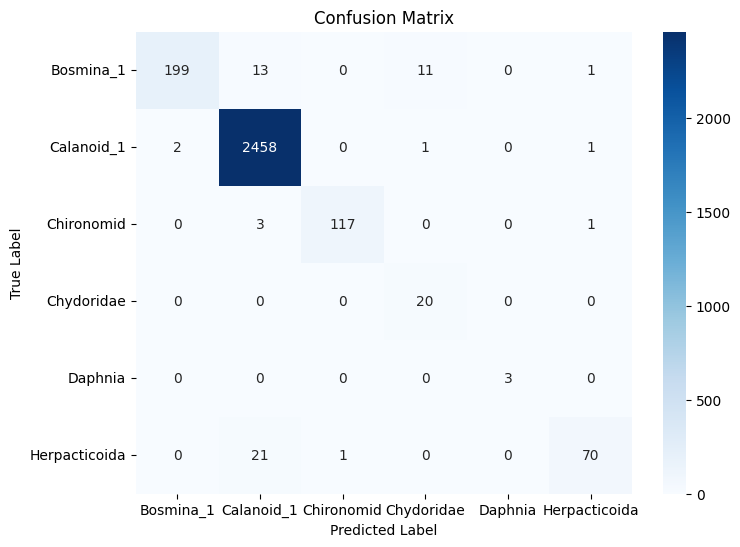

               precision    recall  f1-score   support

    Bosmina_1       0.99      0.89      0.94       224
   Calanoid_1       0.99      1.00      0.99      2462
   Chironomid       0.99      0.97      0.98       121
   Chydoridae       0.62      1.00      0.77        20
      Daphnia       1.00      1.00      1.00         3
Herpacticoida       0.96      0.76      0.85        92

     accuracy                           0.98      2922
    macro avg       0.93      0.94      0.92      2922
 weighted avg       0.98      0.98      0.98      2922



In [29]:
# Load the trained model
collab_model = tf.keras.models.load_model("Modelling/CollaborativeModel/final_collab_model.keras")

# Class label dictionary
class_label_dict = {
    "class_Bosmina_1": "Bosmina_1", 
    "class_Calanoid_1": "Calanoid_1", 
    "class_Chironomid": "Chironomid", 
    "class_Chydoridae": "Chydoridae", 
    "class_Daphnia": "Daphnia", 
    "class_Herpacticoida": "Herpacticoida"
}

# Convert dictionary keys to a sorted list of class names (ensure correct order)
class_names = list(class_label_dict.values())

# Get predicted probabilities
y_pred_probs = collab_model.predict([testAttrX, testImagesX])

# Convert probabilities to class predictions
y_pred = np.argmax(y_pred_probs, axis=1)

# Ensure testY is in integer format (if it's one-hot encoded)
y_true = np.argmax(testY, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Print classification report
print(classification_report(y_true, y_pred, target_names=class_names))

In [30]:
collab_model.summary()

Model: "functional_209"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_21      │ (None, 137)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_22      │ (None, 300, 300,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_207      │ (None, 256)       │    103,168 │ input_layer_21[0… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_208      │ (None, 1536)      │ 12,936,766 │ input_layer_22[0… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 1792)      │          0 │ functional_207[0… │
│ (Concatenate)       │                   │            │ functional_208[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_80 (Dense)    │ (None, 512)       │    918,016 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_81 (Dense)    │ (None, 6)         │      3,078 │ dense_80[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 16,013,650 (61.09 MB)

 Trainable params: 1,026,310 (3.92 MB)

 Non-trainable params: 12,934,718 (49.34 MB)

 Optimizer params: 2,052,622 (7.83 MB)